# Spatial data analysis

We have experimental live cell microscopy data from an experiment that monitored the activity of two important signalling pathways:
ERK and AKT. For this purpose, a cell line was transfected with fluorescent biosensors:

*   H2B-miRFP703 (nuclear tracer),
*   ErkKTR-mTurq.2 (to measure the activity of the RK pathway),
*   FoxO-mNeonGreen (to measure the activity of the AKT pathway)

The experiment was carried out under the following conditions:


1.   Cells were deprived of growth factors for 48 hours prior to imaging
2.   Cells were cultured in 96-well plates coated with fibronectin (0.25 μg/cm^$2$)
3.   Images were acquired every 5 minutes for 24 hours

Each cell (marked with a unique track_id) has a time series of observations covering:
* ERK and AKT activity changes (ERKKTR_ratio, FoxO3A_ratio),
* nucleus size (Nuclear_size),
* spatial location (objNuclei_Location_Centre_X/Y),
* time of observation (Image_Metadata_T)

In addition, each observation is derived from a specific experiment (Exp_ID) and location on the plate (Image_Metadata_Site). We treat the Image_Metadata_Site values as indicators of experimental repetition. The dataset contains observations for cell lines k with different mutations.

Import of necessary libraries and files.

In [ ]:
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.colors
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import multiprocessing as mp
from typing import List, Dict
from scipy.stats import mannwhitneyu, kruskal, spearmanr
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.spatial import KDTree
from tqdm.notebook import tqdm

In [ ]:
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz?raw=true -O single-cell-tracks.csv.gz

data = pd.read_csv("/content/single-cell-tracks.csv.gz")

--2025-04-20 21:17:55--  https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz [following]
--2025-04-20 21:17:55--  https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz [following]
--2025-04-20 21:17:55--  https://media.githubusercontent.com/media/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/single-cell-tracks_exp1

# Initial data exploration

In [ ]:
data.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885


In [ ]:
data.describe()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y
count,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07
mean,3.593846e+00,9.654818e+00,7.631083e+02,1.283255e+02,3.560427e+02,9.047551e-01,1.291381e+00,5.129958e+02,5.097858e+02
std,1.766744e+00,5.682569e+00,6.784322e+02,7.446081e+01,1.289045e+02,2.278312e-01,2.036630e-01,2.970606e+02,2.972352e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,2.078950e+00,2.119400e+00
25%,2.000000e+00,5.000000e+00,2.870000e+02,6.400000e+01,2.789990e+02,7.534900e-01,1.169790e+00,2.558600e+02,2.520280e+02
50%,4.000000e+00,9.000000e+00,5.940000e+02,1.280000e+02,3.330000e+02,8.670850e-01,1.292390e+00,5.147730e+02,5.084320e+02
75%,5.000000e+00,1.400000e+01,1.024000e+03,1.930000e+02,4.069990e+02,1.025020e+00,1.415030e+00,7.711060e+02,7.672950e+02
max,6.000000e+00,2.400000e+01,6.345000e+03,2.570000e+02,2.308000e+03,6.196320e+00,5.403080e+00,1.020310e+03,1.020930e+03


In [ ]:
# Number of experiments in data
experiments = data["Exp_ID"].unique()
print(f"Znaleziono {len(experiments)} eksperymentów: {experiments}")

Znaleziono 6 eksperymentów: [1 2 3 4 5 6]


In [ ]:
# Duration of the experiment
data['Time_min'] = data['Image_Metadata_T'] * 5
max_frame = data['Time_min'].max()
print(f"Długość eksperymentu: {max_frame}min ({max_frame / 60:.2f} godzin)")

Długość eksperymentu: 1285min (21.42 godzin)


In [ ]:
def plot_cells_per_time_per_exp(df: pd.DataFrame, experiments: List[int]) -> None:
    for exp in experiments:
        df_exp = df[df['Exp_ID'] == exp]
        grouped = df_exp.groupby(['Time_min', 'Image_Metadata_Site'])['track_id'].nunique().reset_index()
        grouped = grouped.rename(columns={'track_id': 'cell_count'})

        # Take mean from Image_Metadata_Site
        avg_cells_per_time = grouped.groupby('Time_min')['cell_count'].mean().reset_index()

        fig_hist = px.bar(avg_cells_per_time, x='Time_min', y='cell_count',
                          labels={'Time_min': 'Czas [min]', 'cell_count': 'Średnia liczba komórek'},
                          title=f"Średnia liczba komórek w czasie – Eksperyment {exp}")
        fig_hist.update_layout(bargap=0.2)
        fig_hist.show()

plot_cells_per_time_per_exp(data, experiments)

In [ ]:
def plot_cell_trajectory(df: pd.DataFrame,
                         track_id: int = 1,
                         exp_id: int = 1,
                         site_id: int = 1,
                         show_location: bool = True
                         ) -> None:
    df_cell = df[
              (df['track_id'] == track_id) &
              (df['Exp_ID'] == exp_id) &
              (df['Image_Metadata_Site'] == site_id)
    ]

    if df_cell.empty:
        print(f"Brak danych dla track_id = {track_id}")
        return None

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_cell['Time_min'], y=df_cell['ERKKTR_ratio'],
                             mode='lines+markers', name='ERK', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df_cell['Time_min'], y=df_cell['FoxO3A_ratio'],
                             mode='lines+markers', name='AKT', line=dict(color='red')))

    fig.update_layout(title=f"Trajektoria komórki o trace_id = {track_id} (eksperyment {exp_id}, powtórzenie {site_id})",
                      xaxis_title="Czas [min]", yaxis_title="Poziom sygnału",
                      legend=dict(x=0.02, y=0.98), height=500)
    fig.show()

    if show_location:
        fig_loc = px.scatter(df_cell, x='objNuclei_Location_Center_X', y='objNuclei_Location_Center_Y',
                             title=f"Lokalizacja komórki {track_id} (eksperyment {exp_id}, powtórzenie {site_id})",
                             labels={'objNuclei_Location_Center_X': 'X', 'objNuclei_Location_Center_Y': 'Y'},
                             color='Time_min',)
        fig_loc.update_traces(marker=dict(size=10))
        fig_loc.update_layout(height=500)
        fig_loc.show()

    # Time gaps for 10 minutes interval
    time_gaps = df_cell['Time_min'].diff()
    if (time_gaps > 10).any():
        print(f"Komórka o  track_id={track_id} ma przerwy w czasie w eksperymencie {exp_id}:")
        print(time_gaps[time_gaps > 10])

In [ ]:
# Example of ERK, AKT and spatial position in time
plot_cell_trajectory(data)

In [ ]:
# Example of signal level for different experiments
for exp in experiments:
  plot_cell_trajectory(data, exp_id=exp, show_location=False)

In [ ]:
# Frequency histogram of the number of cells in the field of view
def plot_histogram_cell_counts_per_image(df: pd.DataFrame) -> None:
    grouped = df.groupby(['Exp_ID', 'Image_Metadata_Site', 'Image_Metadata_T'])['track_id'].nunique().reset_index()
    grouped = grouped.rename(columns={'track_id': 'cell_count'})

    # Histogram
    fig = px.histogram(grouped, x='cell_count', color='Exp_ID', barmode='overlay',
                       labels={'cell_count': 'Liczba komórek', 'Exp_ID': 'Eksperyment'},
                       title="Histogram liczby komórek na jednym obrazku (dla wszystkich eksperymentów)",
                       nbins=100)
    fig.update_layout(bargap=0.1)
    fig.show()

plot_histogram_cell_counts_per_image(data)

It is worth noting that there is a fair amount of variation within a single experiment in the repetition of the experiment (*Image_Metadata_Site*). In addition, only experiment 6 was repeated the maximum number of times 24, the other experiments were repeated less.

In [ ]:
# Analysis for different sites of the experiments
for i in range(1, 25, 4):
  print(f"Site = {i}")
  plot_histogram_cell_counts_per_image(data[data["Image_Metadata_Site"] == i])

Site = 1


Site = 5


Site = 9


Site = 13


Site = 17


Site = 21


# Comparison of signalling pathway activity between mutants

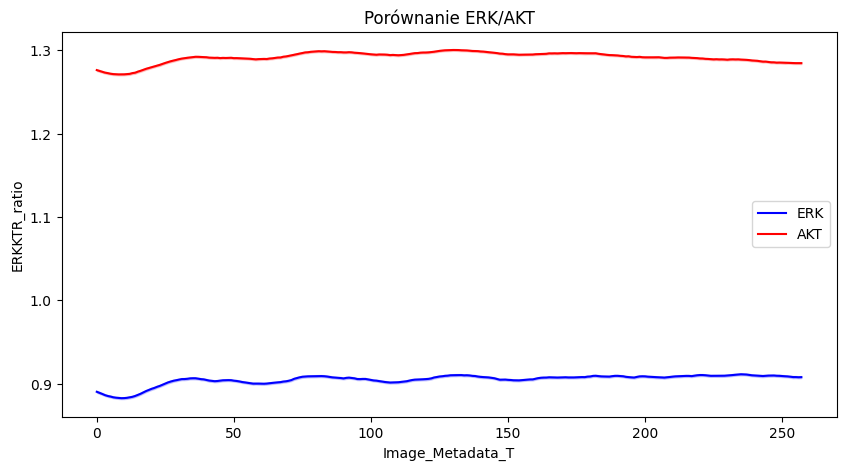

In [ ]:
# ERK/AKT activity trajectories for whole data
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x='Image_Metadata_T', y='ERKKTR_ratio', label='ERK', color='blue')
sns.lineplot(data=data, x='Image_Metadata_T', y='FoxO3A_ratio', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()

From the metadata, we know that different cell lines with the following mutations were used depending on the Image_Metadata_Site:


*   WT (1-4) = 1
*   AKT1-E17K (5-8) = 2
*   PIK3CA-E545K (9 - 12) = 3
*   PIK3CA-H1047R (13 - 16) = 4
*   PTEN (17 - 24) = 5

All mutations except the wild-type (WT) strain increase AKT pathway activity.



In [ ]:
sites = [
    (data['Image_Metadata_Site'] >= 1) & (data['Image_Metadata_Site'] <= 4),
    (data['Image_Metadata_Site'] >= 5) & (data['Image_Metadata_Site'] <= 8),
    (data['Image_Metadata_Site'] >= 9) & (data['Image_Metadata_Site'] <= 12),
    (data['Image_Metadata_Site'] >= 13) & (data['Image_Metadata_Site'] <= 16),
    (data['Image_Metadata_Site'] >= 17),
]

mutations = [1, 2, 3, 4, 5]

data['Mutation'] = np.select(sites, mutations, default=0)

In [ ]:
def plot_mean_signal_with_uncertainty(df: pd.DataFrame,
                                      signal_col: str,
                                      label: str,
                                      legend_dict: Dict[int, str] = None,
                                      mutation_col: str = 'Mutation',
                                      method: str = 'std',  # 'std' or 'percentile'
                                      lower_percentile: float = 5.0,
                                      upper_percentile: float = 95.0) -> None:
    """ The function draws a plot of the average activity
    group by mutation_col with a selected "uncertainty.

    Parameters:
      - df: DataFrame with data, containing columns: Time_min, mutation_col.
      - signal_col: name of signal column (e.g. 'ERKKTR_ratio').
      - label: signal label (used in axis titles of plot).
      - mutation_col: column specifying the mutation (default: Mutation).
      - method: choice of the way to visualise the uncertainty:
          'std' -> area = mean +/- standard deviation.
          'percentile' → area = percentile interval.
      - lower_percentile, upper_percentile: percentiles used
                                            with method 'percentile'.
    """
    # Colors
    colors = plotly.colors.qualitative.Plotly

    if method == 'std':
        grouped = df.groupby(['Time_min', mutation_col])[signal_col].agg(['mean', 'std']).reset_index()
    elif method == 'percentile':
        grouped = df.groupby(['Time_min', mutation_col])[signal_col].agg(
            mean='mean',
            lower=lambda x: np.percentile(x, lower_percentile),
            upper=lambda x: np.percentile(x, upper_percentile)
        ).reset_index()
    else:
        raise ValueError("Unknown method: Use 'std' or 'percentile'.")

    fig = go.Figure()
    mutations = grouped[mutation_col].unique()
    color_map = {mut: colors[i % len(colors)] for i, mut in enumerate(mutations)}

    for mut in mutations:
        g = grouped[grouped[mutation_col] == mut]
        line_color = color_map[mut]

        # Legend
        if legend_dict is not None:
            legend_label = legend_dict.get(mut, str(mut))

        # Colour convertion to RGB
        rgb = plotly.colors.hex_to_rgb(line_color)
        fill_color = f'rgba{rgb + (0.2,)}'

        # MEAN
        fig.add_trace(go.Scatter(
            x=g['Time_min'],
            y=g['mean'],
            mode='lines',
            name=legend_label,
            line=dict(color=line_color, width=2),
            legendgroup=str(mut)
        ))

        # Uncertainty Area
        if method == 'std':
            uncertainty_lower = g['mean'] - g['std']
            uncertainty_upper = g['mean'] + g['std']
        else:
            uncertainty_lower = g['lower']
            uncertainty_upper = g['upper']

        # level of signal is non-negative
        uncertainty_lower = np.maximum(0, uncertainty_lower)

        fig.add_trace(go.Scatter(
            x=np.concatenate([g['Time_min'], g['Time_min'][::-1]]),
            y=np.concatenate([uncertainty_upper, uncertainty_lower[::-1]]),
            fill='toself',
            fillcolor=fill_color,
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False,
            legendgroup=str(mut)
        ))

    fig.update_layout(
        title=f"Średnia aktywność {label} z obszarem niepewności ({method})",
        xaxis_title="Czas [min]",
        yaxis_title=f"{label}",
        height=500
    )

    fig.show()


In [ ]:
legend_dict = {1: 'WT', 2: 'AKT1_E17K', 3: 'PIK3CA_E545K', 4: 'PIK3CA_H1047R', 5: 'PTEN_del'}
plot_mean_signal_with_uncertainty(data, 'ERKKTR_ratio', 'ERK', legend_dict)
plot_mean_signal_with_uncertainty(data, 'FoxO3A_ratio', 'AKT', legend_dict)

In [ ]:
def statistical_test_vs_wt(df: pd.DataFrame,
                          signal_col: str,
                          time_range: tuple = (60, 180),
                          mutation_col: str = 'Mutation',
                          wt_label: int = 1) -> pd.DataFrame:
    """ A function performing a statistical significance test comparing
    mean activity levels between WT and each of the other mutations
    using the Mann-Whitney and Kruskal-Wilis tests.

    Parameters:
      df : DataFrame with data
      signal_col : Name of signal column to be analysed
      time_range : Time range in minutes (default 60-180 minutes)
      mutation_col : Name of column with mutation type
      wt_label : Label for wild type (for comparison with others)

    Returns:
      pd.DataFrame: Datframe with values of statistical tests
    """

    # Filter by time
    df_sel = df[(df['Time_min'] >= time_range[0]) &
               (df['Time_min'] <= time_range[1])]

    # Mean activity
    df_avg = df_sel.groupby([mutation_col, 'Time_min'])[signal_col].mean().reset_index()

    results = []
    wt_values = df_avg[df_avg[mutation_col] == wt_label][signal_col].values

    # Test Mann-Whitney for comparison
    for mut in df_avg[mutation_col].unique():
        if mut == wt_label:
            continue
        mut_values = df_avg[df_avg[mutation_col] == mut][signal_col].values
        stat, p = mannwhitneyu(wt_values, mut_values, alternative='two-sided')
        results.append({
            'Mutation': mut,
            'Test': "Mann–Whitney U",
            'Statistic': stat,
            'P-value': p,
            'Signal': signal_col
        })

    # Bonferroni correction for multiple comparisons
    pvals = [r['P-value'] for r in results]
    _, pvals_corr, _, _ = multipletests(pvals, method='bonferroni')
    for i, p_corr in enumerate(pvals_corr):
        results[i]['Adjusted P-value'] = p_corr

    # Kruskal–Wallis test: across all groups
    groups = [g[signal_col].values for _, g in df_avg.groupby(mutation_col)]
    stat_kw, p_kw = kruskal(*groups)
    results.append({
        'Mutation': 'ALL',
        'Test': 'Kruskal–Wallis',
        'Statistic': stat_kw,
        'P-value': p_kw,
        'Adjusted P-value': None,
        'Signal': signal_col
    })

    return pd.DataFrame(results).sort_values('Adjusted P-value').reset_index(drop=True)

df_erk = statistical_test_vs_wt(data, 'ERKKTR_ratio')
df_akt = statistical_test_vs_wt(data, 'FoxO3A_ratio')

In [ ]:
df_erk.head()

,Mutation,Test,Statistic,P-value,Signal,Adjusted P-value
0,3,Mann–Whitney U,0.00000,1.415656e-09,ERKKTR_ratio,5.662625e-09
1,4,Mann–Whitney U,0.00000,1.415656e-09,ERKKTR_ratio,5.662625e-09
2,5,Mann–Whitney U,0.00000,1.415656e-09,ERKKTR_ratio,5.662625e-09
3,2,Mann–Whitney U,319.00000,9.073220e-01,ERKKTR_ratio,1.000000e+00
4,ALL,Kruskal–Wallis,111.63837,3.254851e-23,ERKKTR_ratio,NaN


In [ ]:
df_akt.head()

,Mutation,Test,Statistic,P-value,Signal,Adjusted P-value
0,2,Mann–Whitney U,0.000000,1.415656e-09,FoxO3A_ratio,5.662625e-09
1,3,Mann–Whitney U,625.000000,1.415656e-09,FoxO3A_ratio,5.662625e-09
2,5,Mann–Whitney U,499.000000,3.074624e-04,FoxO3A_ratio,1.229850e-03
3,4,Mann–Whitney U,327.000000,7.858989e-01,FoxO3A_ratio,1.000000e+00
4,ALL,Kruskal–Wallis,85.665341,1.095987e-17,FoxO3A_ratio,NaN


# Analysis of spatial coordination and signal dynamics

Although the mutations affect the AKT pathway, looking at the P-values and the plots above (larger differences in means and what the signal strength looks like), it seems that the ERK pathway would be the better one to analyse, due to the larger difference in signal strength and more easily detectable peaks.

In [ ]:
def define_states_zscore(
    df: pd.DataFrame,
    signal_col: str = 'ERKKTR_ratio',
    grouping: List[str] = ['Exp_ID', 'Image_Metadata_Site', 'track_id'],
    active_thresh: float = 0.8,
    peak_thresh: float = 2.0) -> pd.DataFrame:
    """ Function Z-score per cell: normalises the signal relative to
    signal_col mean and standard deviation of each cell for each grouping.
    This determines when a cell is inactive, active and has
    the highest signal value - peak.
    """

    df = df.copy()
    df.loc[:, 'zscore'] = df.groupby(grouping)[signal_col]\
                     .transform(lambda x: (x - x.mean()) / x.std())
    def assign_state(z):
        if np.isnan(z): return np.nan
        if z >= peak_thresh: return 'peak'
        if z >= active_thresh: return 'active'
        return 'inactive'
    df.loc[:, 'state'] = df['zscore'].apply(assign_state)
    df.loc[:, 'is_active'] = df['state'].isin(['active', 'peak'])
    return df


for exp in experiments:
    gc.collect()
    sub = data[data['Exp_ID'] == exp]
    sub_processed = define_states_zscore(sub)
    sub_processed = sub_processed.loc[sub.index] # save index
    data.loc[sub_processed.index, ['state', 'is_active']] = sub_processed[['state', 'is_active']]

In [ ]:
def plot_cell_trajectory_with_signal(df: pd.DataFrame,
                         track_id: int = 1,
                         exp_id: int = 1,
                         site_id: int = 1,
                         show_location: bool = True,
                         signal_col: str = 'ERKKTR_ratio'
                         ) -> None:
    """ Function to visualise the signal_col and the position of the
    selected cell depending on the cell state.
    """
    df_cell = df[
        (df['track_id'] == track_id) &
        (df['Exp_ID'] == exp_id) &
        (df['Image_Metadata_Site'] == site_id)
    ]

    if df_cell.empty:
        print(f"Brak danych dla track_id = {track_id}")
        return None

    # Different symbols for cell states
    symbol_map = {
        'inactive': 'circle',
        'active': 'diamond',
        'peak': 'star'
    }

    fig = go.Figure()

    for state, symbol in symbol_map.items():
        df_state = df_cell[df_cell['state'] == state]

        match signal_col:
            case 'ERKKTR_ratio':
                fig.add_trace(go.Scatter(
                    x=df_state['Time_min'], y=df_state['ERKKTR_ratio'],
                    mode='markers',
                    name=f'ERK – {state}',
                    marker=dict(symbol=symbol, color='blue', size=8),
                    line=dict(color='blue'),
                    legendgroup='ERK'
                ))

            case 'FoxO3A_ratio':
                fig.add_trace(go.Scatter(
                    x=df_state['Time_min'], y=df_state['FoxO3A_ratio'],
                    mode='markers',
                    name=f'AKT – {state}',
                    marker=dict(symbol=symbol, color='red', size=8),
                    line=dict(color='red'),
                    legendgroup='AKT',
                    showlegend=True
                ))

    fig.update_layout(
        title=f"Trajektoria komórki o trace_id = {track_id} (Exp_ID {exp_id}, Site {site_id})",
        xaxis_title="Czas [min]",
        yaxis_title="Poziom sygnału",
        height=500
    )
    fig.show()

    if show_location:
        fig_loc = px.scatter(
            df_cell,
            x='objNuclei_Location_Center_X',
            y='objNuclei_Location_Center_Y',
            color='Time_min',
            symbol='state',
            title=f"Lokalizacja komórki {track_id} (Exp_ID {exp_id}, Site {site_id})",
            labels={
                'objNuclei_Location_Center_X': 'X',
                'objNuclei_Location_Center_Y': 'Y'
            }
        )
        fig_loc.update_layout(legend=dict(x=0.02, y=0.98))
        fig_loc.update_traces(marker=dict(size=10))
        fig_loc.update_layout(height=500)
        fig_loc.show()


plot_cell_trajectory_with_signal(data)

In [ ]:
def compute_mean_nn_distance_all(df: pd.DataFrame) -> pd.DataFrame:
    """ Function that counts the average distance to the
    nearest neighbour over time.
    """
    records = []
    for t, df_time in df.groupby('Time_min'):
        coords = df_time[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
        if len(coords) < 2: continue
        tree = KDTree(coords)
        dists, _ = tree.query(coords, k=2)
        nn = dists[:, 1]
        records.append({'Time_min': t, 'mean_nn_distance': nn.mean()})
    return pd.DataFrame(records)

def plot_mean_nn_distance_all(mean_nn_df: pd.DataFrame) -> None:
    """ Function that plots the average distance to the
    nearest neighbour over time.
    """
    fig = px.line(mean_nn_df, x='Time_min', y='mean_nn_distance',
                  labels={'Time_min': 'Czas [min]', 'mean_nn_distance': 'Średnia odległość do NN'},
                  title='Średnia odległość do najbliższego sąsiada w czasie')
    fig.show()

mean_nn_df = compute_mean_nn_distance_all(data[(data['Exp_ID'] == 3) & (data['Image_Metadata_Site'] == 1)])
plot_mean_nn_distance_all(mean_nn_df)

In [ ]:
# Cleaning RAM
gc.collect()
RADIUS = 45.0

In [ ]:
def process_frame(group_data: pd.DataFrame,
                  radius: float = RADIUS) -> Dict[str, float]:
    """ Function to count the number of active and all neighbours
    for a given cell using KDTree for a given radius.
    """
    (exp, site, t), df_time = group_data
    coords_all = df_time[['objNuclei_Location_Center_X','objNuclei_Location_Center_Y']].values
    tree_all = KDTree(coords_all)
    neighbors_all = tree_all.query_ball_point(coords_all, r=radius)
    records = []

    df_active = df_time[df_time['is_active']]
    if not df_active.empty:
        coords_act = df_active[['objNuclei_Location_Center_X','objNuclei_Location_Center_Y']].values
        tree_act = KDTree(coords_act)
        neighbors_active = tree_act.query_ball_point(coords_all, r=radius)
    else:
        neighbors_active = [[] for _ in range(len(coords_all))]

    for loc_idx, orig_idx in enumerate(df_time.index):
        # Not include self
        records.append({
            'orig_index': orig_idx,
            'Num_neighbors_all': max(len(neighbors_all[loc_idx]) - 1, 0),
            'Num_neighbors_active': max(len(neighbors_active[loc_idx]) - 1, 0)
        })
    return records

def compute_neighbors_all_states_mp(df: pd.DataFrame,
                                    radius: float = RADIUS,
                                    n_jobs: int = mp.cpu_count()) -> pd.DataFrame:
    """ Function allows the number of neighbours to be counted
    in parallel (n_jobs) by returning the corresponding df.
    """
    grouped = list(df.groupby(['Exp_ID', 'Image_Metadata_Site', 'Time_min']))
    print(f"Processing {len(grouped)} timeframes using {n_jobs} processes...")

    with mp.Pool(n_jobs) as pool:
        all_lists = list(tqdm(pool.imap_unordered(process_frame, grouped), total=len(grouped)))
    flat = [r for sub in all_lists for r in sub]
    neigh_df = pd.DataFrame(flat).set_index('orig_index')
    return neigh_df

In [ ]:
data['Num_neighbors_active'] = np.nan
data['Num_neighbors_all']    = np.nan

for exp in experiments:
    gc.collect()
    sub = data[data['Exp_ID'] == exp]
    neigh_df = compute_neighbors_all_states_mp(sub, radius=RADIUS)
    # Using index in pandas DataFrame
    data.loc[neigh_df.index, ['Num_neighbors_all','Num_neighbors_active']] =\
            neigh_df[['Num_neighbors_all','Num_neighbors_active']]

# summary
data.head()

Processing 5160 timeframes using 2 processes...


  0%|          | 0/5160 [00:00<?, ?it/s]

Processing 4644 timeframes using 2 processes...


  0%|          | 0/4644 [00:00<?, ?it/s]

Processing 5160 timeframes using 2 processes...


  0%|          | 0/5160 [00:00<?, ?it/s]

Processing 5160 timeframes using 2 processes...


  0%|          | 0/5160 [00:00<?, ?it/s]

Processing 4644 timeframes using 2 processes...


  0%|          | 0/4644 [00:00<?, ?it/s]

Processing 6192 timeframes using 2 processes...


  0%|          | 0/6192 [00:00<?, ?it/s]

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Time_min,Mutation,state,is_active,Num_neighbors_active,Num_neighbors_all
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248,0,1,inactive,False,5.0,11.0
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174,5,1,active,True,6.0,11.0
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787,10,1,peak,True,6.0,10.0
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453,15,1,peak,True,7.0,10.0
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885,20,1,peak,True,8.0,10.0


In [ ]:
# For memory usage
data['Num_neighbors_active'] = data['Num_neighbors_active'].astype('int8')
data['Num_neighbors_all'] = data['Num_neighbors_all'].astype('int8')

In [ ]:
# Plot neighbours for all cells
plot_mean_signal_with_uncertainty(data, 'Num_neighbors_active', 'Active Neighbours', legend_dict)
plot_mean_signal_with_uncertainty(data, 'Num_neighbors_all', 'All Neighbours', legend_dict)

In [ ]:
# Plot neighbours for active cells only
plot_mean_signal_with_uncertainty(data[data['is_active'] == True], 'Num_neighbors_active', 'Active Neighbours', legend_dict)
plot_mean_signal_with_uncertainty(data[data['is_active'] == True], 'Num_neighbors_all', 'All Neighbours', legend_dict)

It is worth noting for the time being the absence of any clear correlations at the level of the average ERK signal level or the average number of neighbours, whether active or all. The next step is to locally consider changes in cell level of signal and spatial position over time.

In [ ]:
def plot_spatial_activity_fragment(
    df: pd.DataFrame,
    exp_id: int,
    site_id: int,
    start_time: int,
    end_time: int,
    which_points : int) -> None:
    """ Function draws spatial maps of the position of cell
    nuclei at successive moments in time, with colouring by state
    and track_id preview, for easier tracking. Displays only
    every 'which_points' times in the time series.

    Parameters:
      - df: DataFrame with columns: i Exp_ID, Image_Metadata_Site, Time_min,
            objNuclei_Location_Center_X/Y, state, track_id
      - exp_id: Experimnet ID (Exp_ID)
      - site_id: Site of Experiment  (Image_Metadata_Site)
      - start_time: starting time of analyse (min)
      - end_time: finishing time of analyse (min)
      - which_points: display only every 'which_points' times in the time series
    """
    df_fs = df[
        (df['Exp_ID'] == exp_id) &
        (df['Image_Metadata_Site'] == site_id) &
        (df['Time_min'] >= start_time) &
        (df['Time_min'] <= end_time)
    ]

    # Selected times
    times = sorted(df_fs['Time_min'].unique())[::which_points]
    df_sel = df_fs[df_fs['Time_min'].isin(times)]

    # Animated graph
    fig = px.scatter(
        df_sel,
        x='objNuclei_Location_Center_X',
        y='objNuclei_Location_Center_Y',
        color='state',
        symbol='state',
        animation_frame='Time_min',
        hover_name='track_id',
        hover_data={
            'Time_min': True,
            'Exp_ID': False,
            'Image_Metadata_Site': False,
            'state': False
        },
        title=f'Spatial activity Exp {exp_id} Site {site_id}',
        labels={
            'objNuclei_Location_Center_X': 'X [µm]',
            'objNuclei_Location_Center_Y': 'Y [µm]',
            'Time_min': 'Czas [min]'
        }
    )

    fig.update_traces(marker={'size': 10})
    fig.update_layout(
        height=600,
        legend_title_text='Stan komórki',
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': False},
                                     'fromcurrent': True}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                       'mode': 'immediate',
                                       'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 90},
            'showactive': True,
            'type': 'buttons',
            'x': 0.1,
            'y': 0
        }]
    )

    fig.show()

In [ ]:
plot_spatial_activity_fragment(data, 1, 1, 840, 960, 1)

From the observation of the top right corner (from 875th minute), it can be inferred that the ERK signal can diffuse locally to neighbouring cells to a large extent, but this does not appear to have a significant effect on cell movement. The statistical significance of this phenomenon could be tested and a regression of the signal level could be attempted.

# How activation of a cell affects its neighbours

In [ ]:
def active_spearman(df: pd.DataFrame,
                    first_column: str = 'is_active',
                    second_column: str = 'Num_neighbors_active') -> tuple:
    """ Function counts correlations between two different columns
    in the dDatafRam, the first one may not be numeric,
    will be converted to float type.
    """
    df_valid = df.dropna(subset=[first_column, second_column])
    rho, pval = spearmanr(df_valid[first_column].astype(float), df_valid[second_column])
    return rho, pval

In [ ]:
# Finding the experiment with the highest correlation
for exp in experiments:
    gc.collect()
    correlation, p_value = active_spearman(data[data['Exp_ID'] == exp])
    print(f"Exp {exp}: Correlation: {correlation} with p-value: {p_value}")

Exp 1: Correlation: 0.4450943200184084 with p-value: 0.0
Exp 2: Correlation: 0.44654743698142746 with p-value: 0.0
Exp 3: Correlation: 0.46378533728257265 with p-value: 0.0
Exp 4: Correlation: 0.4517114848796265 with p-value: 0.0
Exp 5: Correlation: 0.43778180619853874 with p-value: 0.0
Exp 6: Correlation: 0.4441783999669103 with p-value: 0.0


Correlation levels differ only slightly, so without loss of testing our hypothesis we can limit further analysis to only Experiment with ids 3 and 5 (these represent the highest and lowest levels of correlation properly).

In [ ]:
data = data[data['Exp_ID'].isin([3, 5])]
gc.collect()

23

In [ ]:
data.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Time_min,Mutation,state,is_active,Num_neighbors_active,Num_neighbors_all
11542490,3,1,1,0,351.001,0.815142,1.43176,94.7806,86.7322,0,1,inactive,False,0,5
11542491,3,1,1,1,349.000,0.809364,1.40943,94.9628,87.4183,5,1,inactive,False,0,5
11542492,3,1,1,2,354.000,0.812320,1.39814,94.8870,88.0876,10,1,inactive,False,0,6
11542493,3,1,1,3,347.000,0.802506,1.36874,95.3487,87.7550,15,1,inactive,False,0,6
11542494,3,1,1,4,352.001,0.800179,1.35819,94.4062,87.9034,20,1,inactive,False,0,6


In [ ]:
# Looking for other correlations in selected data
for first_column in ['is_active', 'Nuclear_size', 'ERKKTR_ratio']:
    for second_column in ['Num_neighbors_active', 'Num_neighbors_all', 'FoxO3A_ratio']:
        correlation, p_value = active_spearman(data, first_column, second_column)
        print(f"{first_column} vs {second_column}: Correlation: {correlation} with p-value: {p_value}")


is_active vs Num_neighbors_active: Correlation: 0.44781408866664807 with p-value: 0.0
is_active vs Num_neighbors_all: Correlation: -0.033168697528452425 with p-value: 0.0
is_active vs FoxO3A_ratio: Correlation: 0.18699847828810703 with p-value: 0.0
Nuclear_size vs Num_neighbors_active: Correlation: -0.14331416501710348 with p-value: 0.0
Nuclear_size vs Num_neighbors_all: Correlation: -0.5223859843668017 with p-value: 0.0
Nuclear_size vs FoxO3A_ratio: Correlation: 0.09263071737436723 with p-value: 0.0
ERKKTR_ratio vs Num_neighbors_active: Correlation: 0.18494265684497213 with p-value: 0.0
ERKKTR_ratio vs Num_neighbors_all: Correlation: -0.13537937268571476 with p-value: 0.0
ERKKTR_ratio vs FoxO3A_ratio: Correlation: 0.21509182520995676 with p-value: 0.0


In [ ]:
correlation, p_value = active_spearman(data, 'is_active', 'ERKKTR_ratio')
print(f"is_active vs ERKKTR_ratio: Correlation: {correlation} with p-value: {p_value}")

is_active vs ERKKTR_ratio: Correlation: 0.3576588143682577 with p-value: 0.0


Note that whether a cell was active or not was directly determined by the level of the EQF. However, the correlation of these two columns is at the level of 0.35. Of the analysed values, the correlation at a higher level (abolute value) has two pairs Cell Nuclear Size with the number of inactive neighbours and Cell Activity related to the number of active cells. Let us now look at how the variable Nuclear_size looks.

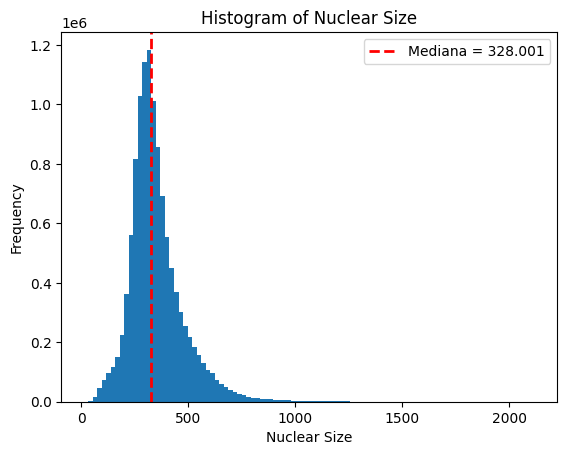

In [ ]:
median_nuclear_size = np.median(data['Nuclear_size'])
plt.hist(data['Nuclear_size'], bins=100)
plt.title('Histogram of Nuclear Size')
plt.xlabel('Nuclear Size')
plt.ylabel('Frequency')
plt.axvline(median_nuclear_size, color='red', linestyle='dashed',
            linewidth=2, label=f'Mediana = {median_nuclear_size}')
plt.legend()
plt.show()

In [ ]:
data['is_active'].value_counts(normalize=True)

,proportion
is_active,
False,0.793736
True,0.206264


In [ ]:
def compute_auc(df: pd.DataFrame) -> float:
    """ Function that builds a logistic regression model on a
    given dataset and then counts the AUC on it to test whether
    there is a non-linear relationship between the ratio of active
    to all neighbours and cell activity.
    """
    df_valid = df.dropna(subset=['is_active','Num_neighbors_active','Num_neighbors_all'])
    X = df_valid[['Num_neighbors_active','Num_neighbors_all']]
    y = df_valid['is_active'].astype(int)

    # for unbalanced dataset
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X, y)
    y_pred = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)


def analyze_site(args: tuple):
    """ Function analysing correlation using the
    active_spearman function and the AUC of the
    logistic regression on a given data set.
    """
    exp_id, site_id, df_site = args
    rho, _ = active_spearman(df_site)
    auc = compute_auc(df_site)
    return {
        'Exp_ID': exp_id,
        'Site': site_id,
        'Spearman_rho': rho,
        'AUC': auc,
    }


def run_analysis_parallel(df: pd.DataFrame,
                          n_jobs: int = mp.cpu_count()) -> pd.DataFrame:
    """ Function calculating correlation and AUC using
    multiprocess to parallelize calculations and
    tqdm to track progress.
    """
    tasks = []
    for exp_id in df['Exp_ID'].unique():
        for site_id in df[df['Exp_ID']==exp_id]['Image_Metadata_Site'].unique():
            gc.collect()
            tasks.append((exp_id, site_id,
                          df[(df['Exp_ID'] == exp_id) &
                           (df['Image_Metadata_Site'] == site_id)]))
    results = []
    with mp.Pool(n_jobs) as pool:
        for res in tqdm(pool.imap_unordered(analyze_site, tasks), total=len(tasks), desc='Sites'):
            results.append({k: res[k] for k in ['Exp_ID','Site','Spearman_rho','AUC']})
    return pd.DataFrame(results)


In [ ]:
summary = run_analysis_parallel(data)
print(summary)

Sites:   0%|          | 0/38 [00:00<?, ?it/s]

    Exp_ID  Site  Spearman_rho       AUC
0        3     1      0.486542  0.824762
1        3     2      0.475124  0.820988
2        3     3      0.527592  0.839894
3        3     4      0.509156  0.829284
4        3     5      0.379846  0.775428
5        3     6      0.368013  0.767484
6        3     7      0.416364  0.785789
7        3     8      0.417127  0.786640
8        3    10      0.475251  0.819106
9        3     9      0.454437  0.812143
10       3    12      0.475556  0.819492
11       3    11      0.465734  0.811500
12       3    13      0.672631  0.900030
13       3    14      0.673121  0.899629
14       3    15      0.690648  0.905704
15       3    16      0.653327  0.889019
16       3    17      0.518611  0.801236
17       3    18      0.491333  0.797639
18       3    19      0.499411  0.793201
19       3    20      0.509697  0.792795
20       5     1      0.446256  0.816299
21       5     2      0.457695  0.822412
22       5     3      0.448504  0.815802
23       5     4

# Sanity Check

In the project description we can see that the mutations cause increased **AKT** activity, whereas the wild-type strain does not have the lowest average at all. But as you can see, biology can sometimes be surprising because it agrees with other data from the same experiment.

In [ ]:
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/WT.csv.gz?raw=true -O wt.csv.gz
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/AKT1-E17K.csv.gz?raw=true -O akt.csv.gz
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/PIK3CA-E545K.csv.gz?raw=true -O pik.csv.gz

data_wt = pd.read_csv("/content/wt.csv.gz")
data_akt = pd.read_csv("/content/akt.csv.gz")
data_pik = pd.read_csv("/content/pik.csv.gz")

--2025-04-20 21:43:41--  https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/WT.csv.gz?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/WT.csv.gz [following]
--2025-04-20 21:43:42--  https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/WT.csv.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/WT.csv.gz [following]
--2025-04-20 21:43:42--  https://raw.githubusercontent.com/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/WT.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercon

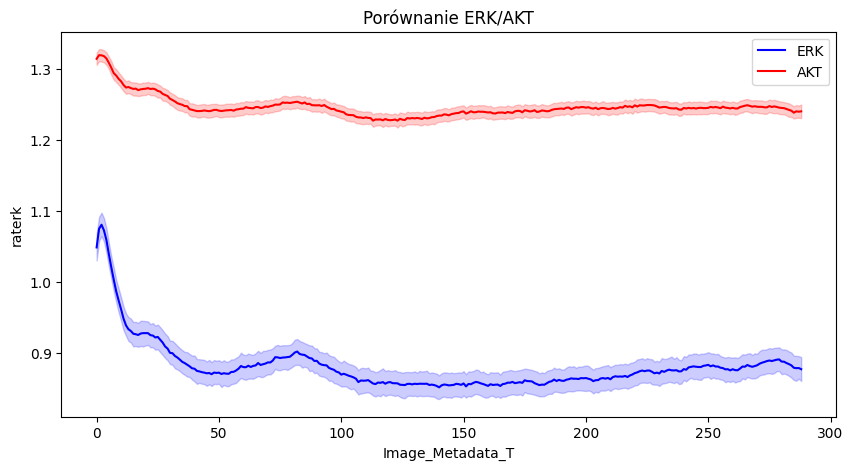

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data_wt, x='Image_Metadata_T', y='raterk', label='ERK', color='blue')
sns.lineplot(data=data_wt, x='Image_Metadata_T', y='ratakt', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()

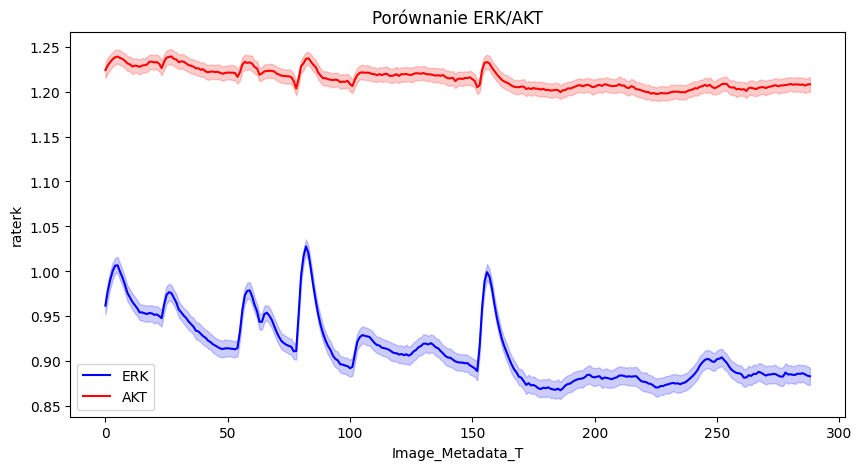

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data_pik, x='Image_Metadata_T', y='raterk', label='ERK', color='blue')
sns.lineplot(data=data_pik, x='Image_Metadata_T', y='ratakt', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()

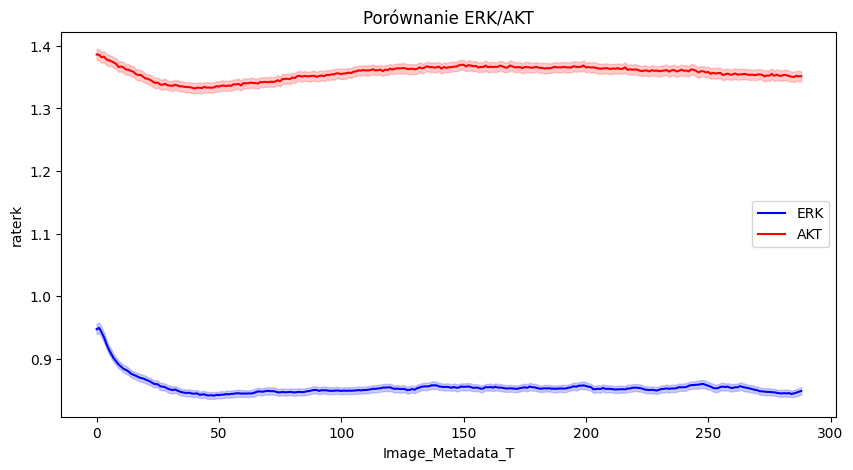

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data_akt, x='Image_Metadata_T', y='raterk', label='ERK', color='blue')
sns.lineplot(data=data_akt, x='Image_Metadata_T', y='ratakt', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()